In [1]:
import sys
sys.path.append('/home/g201381710/ExperimentsGH/DotlessArabic2/DotlessArabic')
sys.path.append('/home/g201381710/.local/lib/python3.10/site-packages')
sys.path.append('/home/g201381710/anaconda3/envs/dl4/lib/python3.10/site-packages')

sys.path

['/home/g201381710/ExperimentsGH/DotlessArabic2/DotlessArabic/dotless_arabic/analysis/notebooks',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/g201381710/.local/lib/python3.10/site-packages',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages/IPython/extensions',
 '/home/g201381710/.ipython',
 '/home/g201381710/ExperimentsGH/DotlessArabic2/DotlessArabic',
 '/home/g201381710/.local/lib/python3.10/site-packages',
 '/home/g201381710/anaconda3/envs/dl4/lib/python3.10/site-packages']

In [2]:
import re,random,math
from collections import Counter
from functools import lru_cache

from farasa.segmenter import FarasaSegmenter

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import linregress

from dotless_arabic.processing import process,undot

from dotless_arabic.tokenizers import DisjointLetterTokenizer,FarasaMorphologicalTokenizer, WordTokenizer

from dotless_arabic.datasets.news.collect import collect_dataset_for_analysis as collect_news_dataset_for_analysis
from dotless_arabic.datasets.quran.collect import collect_dataset_for_analysis as collect_quran_dataset_for_analysis
from dotless_arabic.datasets.poems.collect import collect_dataset_for_analysis as collect_poems_dataset_for_analysis
from dotless_arabic.datasets.wikipedia.collect import collect_dataset_for_analysis as collect_wikipedia_dataset_for_analysis
from dotless_arabic.datasets.aggregated.collect import collect_dataset_for_analysis as collect_aggregated_dataset_for_analysis
from dotless_arabic.datasets.sanadset_hadeeth.collect import collect_dataset_for_analysis as collect_sanadset_hadeeth_dataset_for_analysis

In [3]:
random.seed(42)

# functions

In [4]:
tokenizer = WordTokenizer()

In [5]:
@lru_cache()
def tokenize_dataset(dataset):
    tokenized_dataset = list()
    if isinstance(tokenizer,FarasaMorphologicalTokenizer):
        segmenter = FarasaSegmenter(interactive=True)
    for document in tqdm(dataset):
        if isinstance(tokenizer,FarasaMorphologicalTokenizer):
            tokenized_document = " ".join(
                tokenizer.split_text(
                    document,
                    segmenter=segmenter,
                )
            )
        else:
            tokenized_document = " ".join(tokenizer.split_text(document))
        tokenized_document = tokenized_document.replace("<##>", "")
        tokenized_document = re.sub("\s+", " ", tokenized_document)
        tokenized_dataset.append(tokenized_document)
    return tokenized_dataset

In [6]:
@lru_cache()
def words_counter(dataset,use_tqdm=True):
    if not use_tqdm:
        return Counter(word for item in dataset for word in item.split())    
    return Counter(word for item in tqdm(dataset) for word in item.split())

@lru_cache()
def undot_dataset(dataset):
    return list(map(undot, tqdm(dataset)))

@lru_cache()
def process_dataset(dataset):
    return list(map(process, tqdm(dataset)))

In [7]:
# tokenize datasets
all_datasets = [
    tokenize_dataset(dataset=tuple(collect_quran_dataset_for_analysis())),
    tokenize_dataset(dataset=tuple(collect_sanadset_hadeeth_dataset_for_analysis())),
    tokenize_dataset(dataset=tuple(collect_poems_dataset_for_analysis())),
    tokenize_dataset(dataset=tuple(collect_wikipedia_dataset_for_analysis())),
    tokenize_dataset(dataset=tuple(collect_news_dataset_for_analysis())),
#     tokenize_dataset(dataset=tuple(collect_raw_aggregated_dataset())),
]

aggregated_dataset = []
for _dataset in all_datasets:
    aggregated_dataset.extend(_dataset)
all_datasets.append(aggregated_dataset)

  0%|          | 0/6236 [00:00<?, ?it/s]

####################################################################################################
Original Number of Samples:
650,986
####################################################################################################
####################################################################################################
Number of Samples after dropping duplicates:
637,565
####################################################################################################


  0%|          | 0/637565 [00:00<?, ?it/s]

Using custom data configuration MagedSaeed--ashaar-719bb58a76ea0092
Found cached dataset parquet (/home/g201381710/.cache/huggingface/datasets/arbml___parquet/MagedSaeed--ashaar-719bb58a76ea0092/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/7714858 [00:00<?, ?it/s]

  0%|          | 0/4636663 [00:00<?, ?it/s]

  0%|          | 0/2784041 [00:00<?, ?it/s]

In [8]:
# process datasets
all_datasets = [
    process_dataset(dataset=tuple(all_datasets[0])),
    process_dataset(dataset=tuple(all_datasets[1])),
    process_dataset(dataset=tuple(all_datasets[2])),
    process_dataset(dataset=tuple(all_datasets[3])),
    process_dataset(dataset=tuple(all_datasets[4])),
#     process_dataset(dataset=tuple(datasets[5])),
]

aggregated_dataset = []
for _dataset in all_datasets:
    aggregated_dataset.extend(_dataset)  
all_datasets.append(aggregated_dataset)

  0%|          | 0/6236 [00:00<?, ?it/s]

  0%|          | 0/637565 [00:00<?, ?it/s]

  0%|          | 0/7714858 [00:00<?, ?it/s]

  0%|          | 0/4636663 [00:00<?, ?it/s]

  0%|          | 0/2784041 [00:01<?, ?it/s]

In [9]:
for dataset in tqdm(all_datasets):
    random.shuffle(dataset)

  0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
all_datasets_names = [
    'quran',
    'sanadset hadeeth',
    'poems',
    'wikipedia',
    'news',
    'aggregated',
]

In [11]:
# we may need to report the error on the regression line: MSE, MAE, etc.
def get_heaps_law_constants(dataset,get_points_list=False,clear_lru_cache=False):
  X,Y = [],[]
  vocabulary = set()
  number_of_tokens = 0
  for index in tqdm(range(len(dataset))):
    
    counter = words_counter(
        tuple([dataset[index]]),
        use_tqdm=False,
    )
    
    number_of_tokens += sum(counter.values())
    X.append(
        math.log(
            number_of_tokens,
             math.e, #base
          ),
      )
    
    vocabulary.update(counter.keys())
    Y.append(
        math.log(
            len(vocabulary),
             math.e, #base
          ),
      )
    
    if clear_lru_cache:
      words_counter.cache_clear()
    
  slope,intercept,*_= linregress(X,Y)

  b = slope
  k = math.e**intercept

  if get_points_list:
    return b,k,(X,Y)
  return b,k

In [12]:
get_heaps_law_constants(dataset=all_datasets[0])

  0%|          | 0/6236 [00:00<?, ?it/s]

(0.7120847527482476, 5.1305633638163135)

In [13]:
def plot_heaps(
    datasets=all_datasets,
    datasets_names=all_datasets_names,
    figsize=(25,15),
  ):

  unlog = lambda points: list(map(lambda point: math.e**point,points))

  plt.figure(figsize=figsize)
    
  for dataset,dataset_name in zip(datasets,datasets_names):
        
      beta,k,(X,Y) = get_heaps_law_constants(dataset,get_points_list=True)
      print()
      print('-'*100)
      print('-'*100)
      print('beta: ',beta,' k ',k,' for dataset: ',dataset_name)

      print('some samples of the dotted X,Y lists:')  
      print(list(map(lambda item: round(item,2),unlog(X[:10]))))
      print(list(map(lambda item: round(item,2),unlog(Y[:10]))))
        
      if 'aggregated' in dataset_name:
        undotted_dataset = []
        for dataset in all_datasets[:-1]:
            undotted_dataset.extend(undot_dataset(dataset=tuple(dataset)))
        random.shuffle(undotted_dataset)
      else:
        undotted_dataset = undot_dataset(dataset=tuple(dataset))
        
      undotted_beta,undotted_k,(undotted_X,undotted_Y) = get_heaps_law_constants(undotted_dataset,get_points_list=True)
      print('-'*100)
      print('undotted beta: ',undotted_beta,' undotted k ',undotted_k, ' for dataset: ',dataset_name)
      print('-'*100)
      print('-'*100)
      print()
       
      plt.plot(unlog(X),unlog(Y),label=f'{dataset_name} dataset (k={k:.3f},β={beta:.3f})')
      plt.plot(
          unlog(X),
          [k*x**beta for x in unlog(X)],
          label=f'dotted regression fit for {dataset_name}',
          linestyle='dashed',
      )
      # https://stackoverflow.com/a/41308516/4412324
      # plt.text(
      #     x=0.73,
      #     y=0.95,
      #     s=f'dotted: k={k:.3f},β={beta:.3f}',
      #     transform=plt.gca().transAxes,
      #     fontsize=12,
      # )
    
      plt.plot(unlog(undotted_X),unlog(undotted_Y),label=f'undotted {dataset_name} dataset (k={undotted_k:.3f},β={undotted_beta:.3f})')
      plt.plot(
          unlog(undotted_X),
          [undotted_k*x**undotted_beta for x in unlog(undotted_X)],
          label=f'undotted regression fit for {dataset_name}',
          linestyle='dashed',
      )
        
      # plt.text(
      #     x=0.73,
      #     y=0.92,
      #     s=f'undotted: k={undotted_k:.3f},β={undotted_beta:.3f}',
      #     transform=plt.gca().transAxes,
      #     fontsize=12,
      # )
    
      plt.legend(loc='lower right',fontsize=14)
      plt.ylim(ymin=0)
      plt.xlim(xmin=0)
      # https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller
      plt.xticks(fontsize=14)
      plt.yticks(fontsize=14)
      # https://stackoverflow.com/questions/34227595/how-to-change-font-size-of-the-scientific-notation-in-matplotlib
      # https://stackoverflow.com/questions/21512305/inconsistent-font-size-for-scientific-notation-in-axis
      plt.rc('font',size=12)

  0%|          | 0/6236 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.7120847527482476  k  5.1305633638163135  for dataset:  quran
some samples of the dotted X,Y lists:
[4.0, 8.0, 46.0, 58.0, 69.0, 73.0, 75.0, 80.0, 103.0, 135.0]
[4.0, 8.0, 42.0, 51.0, 61.0, 65.0, 67.0, 72.0, 90.0, 113.0]


  0%|          | 0/6236 [00:00<?, ?it/s]

  0%|          | 0/6236 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.7018293949978689  undotted k  5.487487736313078  for dataset:  quran
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



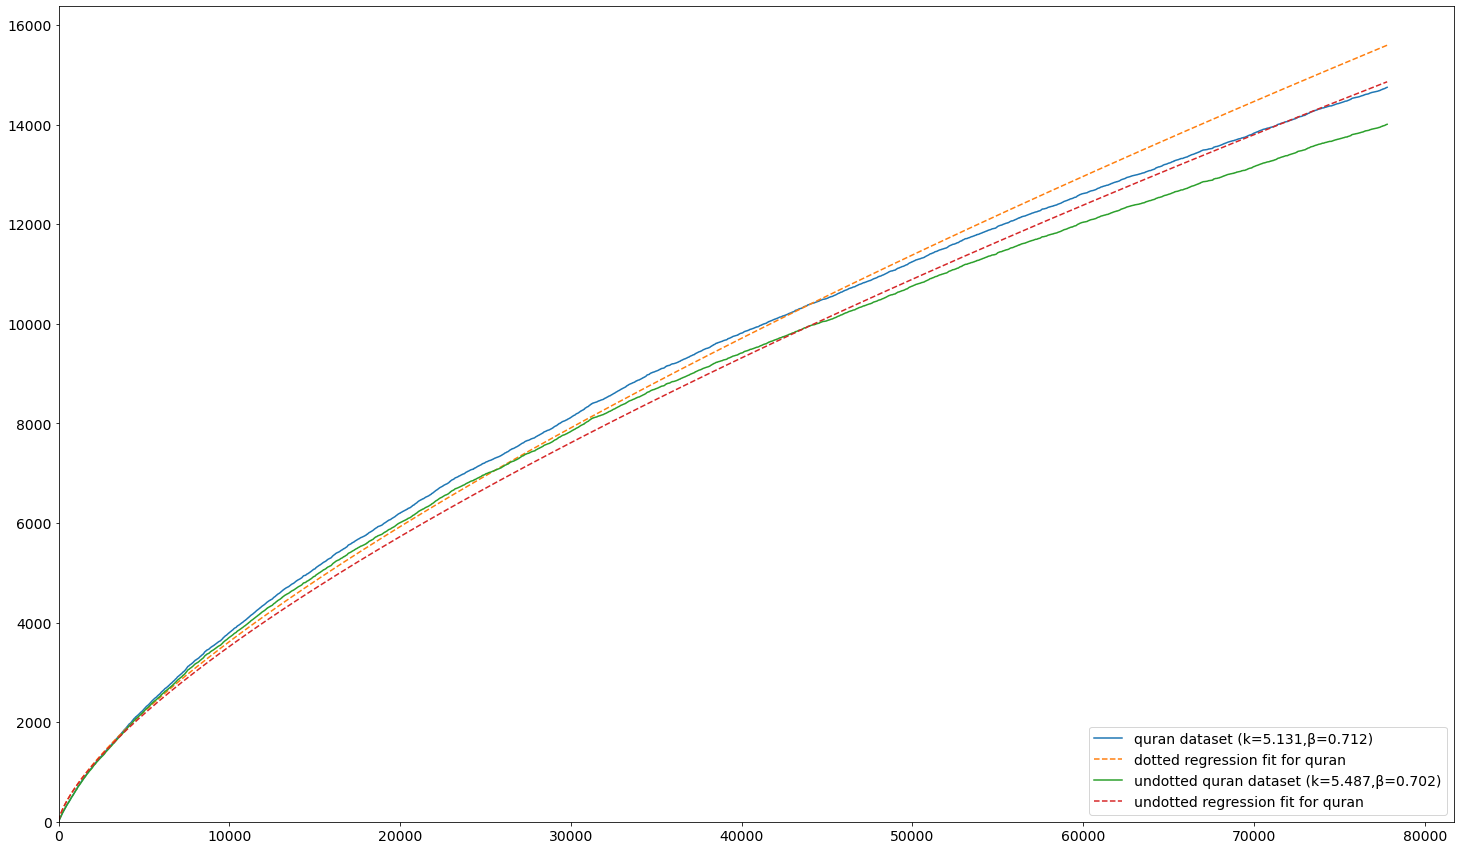

In [14]:
plot_heaps(
    datasets=[all_datasets[0]],
    datasets_names=[all_datasets_names[0]],
)

  0%|          | 0/15779363 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.4937665017930814  k  158.68272015693913  for dataset:  aggregated
some samples of the dotted X,Y lists:
[29.0, 36.0, 47.0, 51.0, 97.0, 166.0, 240.0, 245.0, 270.0, 275.0]
[28.0, 35.0, 44.0, 48.0, 88.0, 149.0, 196.0, 201.0, 220.0, 225.0]


  0%|          | 0/637565 [00:00<?, ?it/s]

  0%|          | 0/7714858 [00:00<?, ?it/s]

  0%|          | 0/4636663 [00:00<?, ?it/s]

  0%|          | 0/2784041 [00:00<?, ?it/s]

  0%|          | 0/15779363 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.4706803966503289  undotted k  189.00514506928073  for dataset:  aggregated
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



  0%|          | 0/2784041 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.44791239685220474  k  207.70554392990655  for dataset:  news
some samples of the dotted X,Y lists:
[68.0, 123.0, 147.0, 241.0, 273.0, 304.0, 351.0, 374.0, 377.0, 428.0]
[60.0, 106.0, 125.0, 201.0, 230.0, 257.0, 292.0, 310.0, 313.0, 351.0]


  0%|          | 0/2784041 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.4255523074448134  undotted k  257.75498390015014  for dataset:  news
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



  0%|          | 0/4636663 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.5248278352898426  k  82.83069323491543  for dataset:  wikipedia
some samples of the dotted X,Y lists:
[5.0, 41.0, 53.0, 109.0, 205.0, 249.0, 316.0, 351.0, 354.0, 457.0]
[5.0, 40.0, 50.0, 95.0, 167.0, 199.0, 248.0, 273.0, 275.0, 335.0]


  0%|          | 0/4636663 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.5039647491725033  undotted k  99.53340322415015  for dataset:  wikipedia
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



  0%|          | 0/7714858 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.5061049325620803  k  161.10720092397835  for dataset:  poems
some samples of the dotted X,Y lists:
[6.0, 12.0, 17.0, 23.0, 28.0, 32.0, 37.0, 42.0, 46.0, 52.0]
[6.0, 12.0, 17.0, 23.0, 27.0, 31.0, 35.0, 40.0, 44.0, 49.0]


  0%|          | 0/7714858 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.46904103685663856  undotted k  216.02219098381673  for dataset:  poems
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



  0%|          | 0/637565 [00:00<?, ?it/s]


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
beta:  0.4622558811785948  k  118.41644660075504  for dataset:  sanadset hadeeth
some samples of the dotted X,Y lists:
[30.0, 66.0, 100.0, 129.0, 172.0, 196.0, 221.0, 289.0, 323.0, 329.0]
[23.0, 50.0, 74.0, 90.0, 113.0, 122.0, 136.0, 172.0, 186.0, 190.0]


  0%|          | 0/637565 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
undotted beta:  0.43536453853585266  undotted k  150.55084001290152  for dataset:  sanadset hadeeth
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



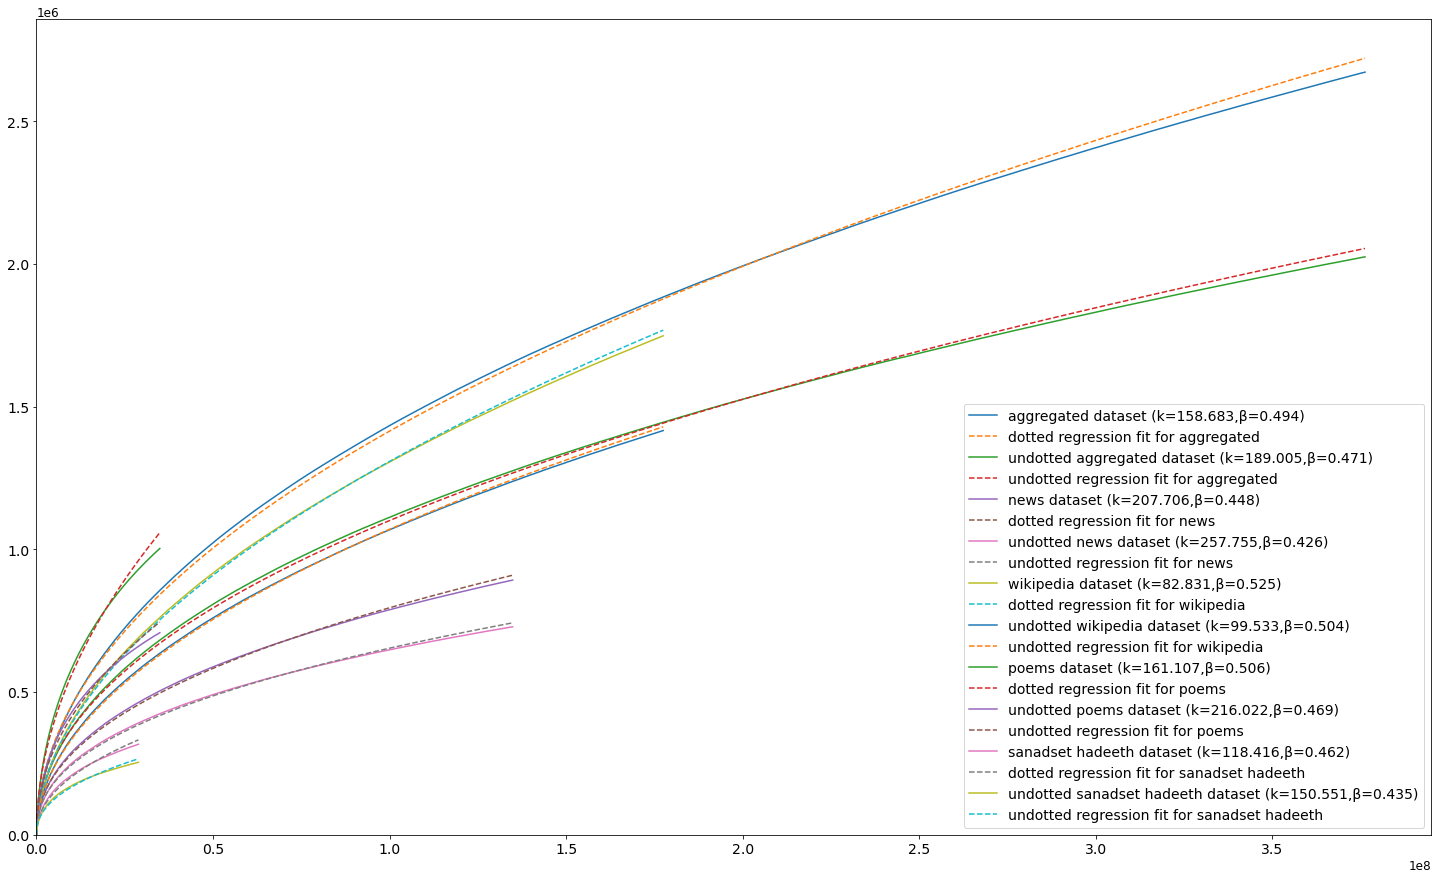

In [15]:
plot_heaps(
    datasets=all_datasets[:0:-1],
    datasets_names=all_datasets_names[:0:-1],
)